<a href="https://colab.research.google.com/github/Priyanshi2205/Customer-Segmentation---RFM-Analysis/blob/main/RFM_Analysis_Customer_Segmentation_Hierarchical_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation**

**RFM:**

`Recency`: how recently a customer has purchased

`Frequency`: how often they purchased 

`Monetary`: how much the customer spends


In [ ]:
#importing all relevant liabraries

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/OnlineRetail.csv", sep=",", encoding="ISO-8859-1", header=0)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
#Checking null values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#Cleaning Null values
data = data.dropna()

In [ ]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

# Preparing data for modelling


In [ ]:
#first creating the column indicating revenue contributed per customer
data['revenue'] = data['Quantity']*data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [ ]:
revenue_contributed = data.groupby('CustomerID')['revenue'].sum()
revenue_contributed = revenue_contributed.reset_index()
revenue_contributed.head()

,CustomerID,revenue
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
frequency = data.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['duration'] = data['InvoiceDate'].max() - data['InvoiceDate']
data['duration']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,duration
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
recency = data.groupby('CustomerID')['duration'].min()
recency = recency.reset_index()
recency.head()

,CustomerID,duration
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
#merging data
rf = pd.merge(revenue_contributed, frequency, on='CustomerID', how='inner')
rfm = pd.merge(rf, recency, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'revenue', 'frequency', 'recency']
rfm['recency'] = rfm['recency'].dt.days
rfm.head()

,CustomerID,revenue,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


# Outlier treatment

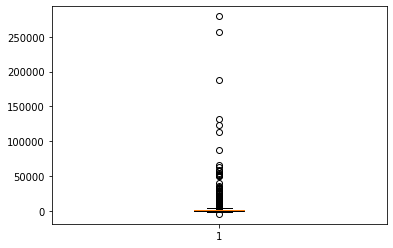

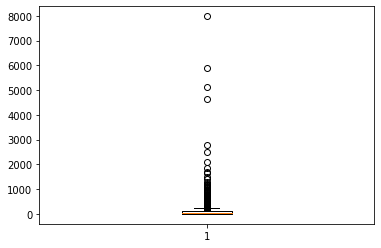

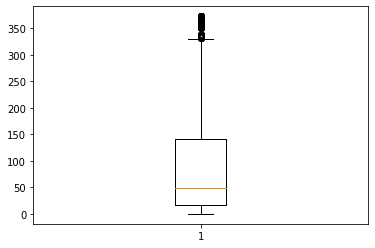

In [ ]:
plt.boxplot(rfm['revenue'])
plt.show()
plt.boxplot(rfm['frequency'])
plt.show()
plt.boxplot(rfm['recency'])
plt.show()

In [ ]:
q1_rev = rfm['revenue'].quantile(0.05)
q3_rev= rfm['revenue'].quantile(0.95)
IQR = q3_rev - q1_rev
rfm = rfm[(rfm['revenue'] >= q1_rev - 1.5*IQR) & (rfm['revenue'] <= q3_rev + 1.5*IQR)]

q1_freq = rfm['frequency'].quantile(0.05)
q3_freq = rfm['frequency'].quantile(0.95)
IQR = q3_freq - q1_freq
rfm = rfm[(rfm['frequency'] >= q1_freq - 1.5*IQR) & (rfm['frequency'] <= q3_freq + 1.5*IQR)]

q1_rec = rfm['recency'].quantile(0.05)
q3_rec = rfm['recency'].quantile(0.95)
IQR = q3_rec - q1_rec
rfm = rfm[(rfm['recency'] >= q1_rec - 1.5*IQR) & (rfm['recency'] <= q3_rec + 1.5*IQR)]


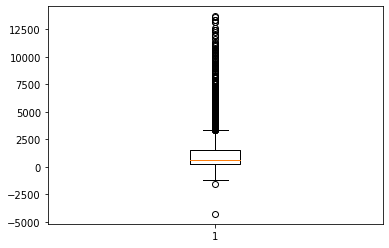

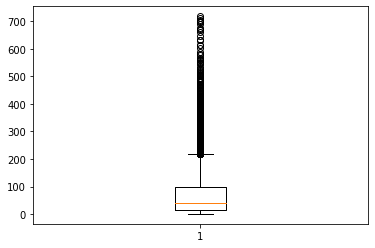

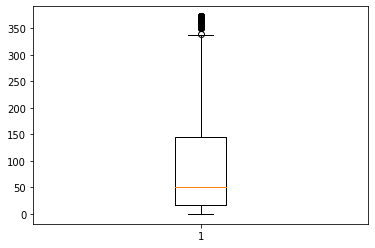

In [ ]:
plt.boxplot(rfm['revenue'])
plt.show()
plt.boxplot(rfm['frequency'])
plt.show()
plt.boxplot(rfm['recency'])
plt.show()

https://www.youtube.com/watch?v=A3gClkblXK8            to understand outlier

In [ ]:
#Scaling the features
scale = StandardScaler()
cols = ['revenue', 'frequency', 'recency']
rfm_scaler = scale.fit_transform(rfm[cols])

In [ ]:
rfm_scaled = pd.DataFrame(rfm_scaler)
rfm_scaled.columns = ['revenue', 'frequency', 'recency']
rfm_scaled.head()

,revenue,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# Hopkins Statistic

In [ ]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [ ]:
hopkins(rfm_scaled)

0.9571735230892067

# Building Model (Hierarchial Cluster)

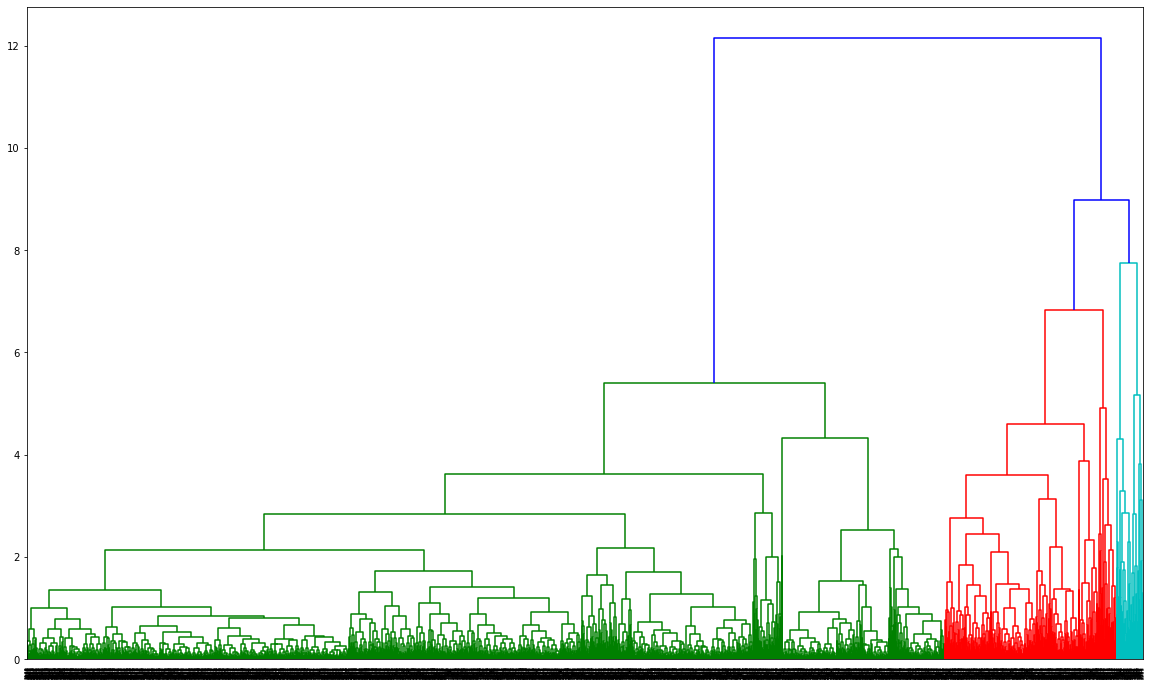

In [ ]:
# complete linkage
plt.figure(figsize=(20,12))

mergings = linkage(rfm_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [ ]:

# clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
# assign cluster labels
pd.set_option('display.max_rows', None)
rfm['cluster_labels'] = cluster_labels
rfm.head(90)

,CustomerID,revenue,frequency,recency,cluster_labels
0,12346.0,0.000000e+00,2,325,0
1,12347.0,4.310000e+03,182,1,1
2,12348.0,1.797240e+03,31,74,0
3,12349.0,1.757550e+03,73,18,0
4,12350.0,3.344000e+02,17,309,0
5,12352.0,1.545410e+03,95,35,0
6,12353.0,8.900000e+01,4,203,0
7,12354.0,1.079400e+03,58,231,0
8,12355.0,4.594000e+02,13,213,0
9,12356.0,2.811430e+03,59,22,1


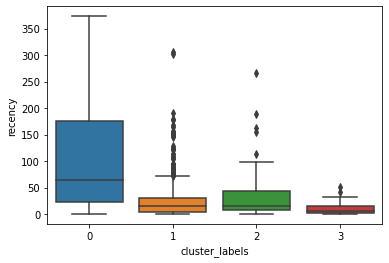

In [ ]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=rfm)

0 cluster indicates that customers belonging to 0 cluster have not visited for a long time on their website
1 and 2 cluster correspondes to that customer who are very recent visitors on the website

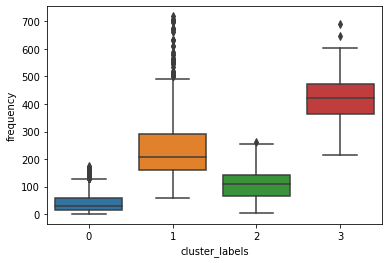

In [ ]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=rfm)

here in frequency cluster 0 coresponds to customer who are very less frequent in purchasing. and so on

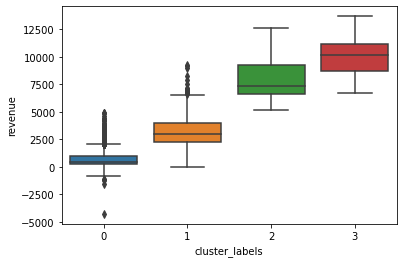

In [ ]:
# plots
sns.boxplot(x='cluster_labels', y='revenue', data=rfm)

cluster 2 here is most important. As they are  the are customers who are contributing highest to the revenue 

# Conclusion

After analysing all of the models, we can come to the following conclusions. i.e., we've categorised clients who are similar in order to report and analyse data from our database. It allows you to spot trends in how you've acquired consumers and how different categories have interacted with your business. This allows you to learn more about what connects with different types of prospects during the marketing and sales process, as well as what forms of communications they like during service delivery.Knowing what your most successful customers have in common will help you better target your customer acquisition efforts.The input you receive from various segments will help you understand how your service is assisting your clients.This might help you figure out how to pitch your solution to prospects and identify demands that you can address in the future with new products or services.
